# Übung 6

**Gruppenname:**

*Team BBM*

Gehen Sie wie folgt vor:

1. Bitte benennen Sie jetzt dieses Jupyter Notebook um (z.B. über `File -> Rename`):

   Namensschema: `Gruppenname-X`. Ersetzen Sie "X" mit der oben angegebenen Nummer der Übung.

   - Beispiel 1: Team REZA bearbeitet Übung 2. Das Notebook heißt: REZA-2.
   - Beispiel 2: Sie sind keinem Team zugeordnet (nicht empfehlenswert) und bearbeiten Übung 2: Ihr Notebook heißt: Nachname-2.


2. Tragen Sie Ihren Gruppennamen auch ganz oben bei "Name Ihrer Gruppe" ein.

3. Bearbeiten Sie dann dieses Notebook. Vergessen Sie dabei nicht, das Jupyter Notebook regelmäßig zu speichern (z.B. über `Strg + S` oder über `File -> Save and Checkpoint`).

### In dieser Übung ...

... werden wir intensiv mit Dimensionsreduktion mittels Hauptkomponentenzerlegung (PCA) beschäftigen. Wir werden die PCA implementieren und damit verschiedene Datensätze untersuchen.

### 6.1 Eigengesichter (Bildkompression mittels PCA)

In den 90er Jahren haben Forscher des Olivetti Research Laboratory in Cambridge, basierend auf der PCA, eines der frühen Verfahren für Gesichtserkennung entwickelt. Das Olivetti Research Laboratory wurde wenige Jahre später von AT&T übernommen, und der [Datensatz](https://web.archive.org/web/20051104013331/http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html), auf dem die Arbeiten beruhten, wurde unter dem Namen *Olivetti Faces Dataset* weltweit bekannt.

Wir werden uns in dieser Übung mit dem Aspekt der Dimensionsreduktion mithilfe von PCA beschäftigen, und wie sie zur Datenkompression von Gesichtsbildern eingesetzt werden kann. Die PCA-Richtungen (Hauptkomponenten) eines Datensatzes von Gesichtsbildern werden auch *Eigengesichter* bzw. *Eigenfaces* genannt.

**Ihre Daten**

Die Olivetti Faces bestehen aus 400 Graustufenbildern (64x64 Pixel), die von 40 Personen stammen. Von jeder Person wurden 10 Gesichtsbilder angefertigt, wobei die Personen gebeten wurden, unterschiedliche Gesichtsausdrücke zu zeigen. Gleichzeitig wurde die Beleuchtung während der Fotoaufnahmen variiert.

* Importieren Sie den Datensatz durch das Ausführen der untenstehenden Code-Zelle.

In [5]:
import io
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np
import seaborn as sbn
import seaborn_image as isbn
from matplotlib import pyplot as plt
import ipywidgets as widgets
# from pandas.conftest import axis
from networkx import bipartite_layout
from scipy.ndimage import label
from sklearn.datasets import fetch_olivetti_faces
from skimage.exposure import adjust_gamma
from skimage.exposure import rescale_intensity
from sklearn.datasets import make_swiss_roll
from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import shortest_path
from sklearn.neighbors import kneighbors_graph
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

In [1]:
# import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

# Import data
data, targets = fetch_olivetti_faces(return_X_y=True)

**Ihre Aufgaben**

* Bei der Implementierung der PCA in den nachfolgenden Teilaufgaben nutzen Sie bitte ausschließlich *Numpy* und keine Funktionen von sklearn.

(1) Untersuchen Sie die Daten in `data`: 

* Nennen Sie die Anzahl der Samples (Gesichter) in diesem Datensatz.
* Nennen Sie die Anzahl der Features (Merkmale, Pixel) jedes Gesichts.
* Prüfen Sie, in welchem Wertebereich die Pixelwerte variieren und nennen Sie den Wertebereich.

In [15]:
# Anzahl der Samples 
n_samples = data.shape[0]
print(f"Anzahl der Samples: {n_samples}")

# Anzahl der Features
n_features = data.shape[1]
print(f"Anzahl der Features: {n_features}")

# Wertebereich der Features
print(f"Wertebereich der Features: {data.min()} - {data.max()}")

Anzahl der Samples: 400
Anzahl der Features: 4096
Wertebereich der Features: 0.0 - 1.0


(2) Nutzen Sie Ihre Erkenntnisse aus (1) und visualisieren Sie das Gesicht 296 (0-basierte Zählung).

* Dabei kann Ihnen [dieser Befehl](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html?highlight=reshape#numpy.ndarray.reshape) und [jener Befehl](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) hilfreich sein. Wenn Sie `cmap=gray` verwenden, dann wird das Gesicht in Graustufen dargestellt.

In [16]:
# using nump.reshape and matplotlib.pyplot.imshow
# using slider
from ipywidgets import interact

def slider(i):
    plt.imshow(data[i, :].reshape(64, 64), cmap='gray')

interact(slider, i=(0, n_samples-1))


interactive(children=(IntSlider(value=199, description='i', max=399), Output()), _dom_classes=('widget-interac…

<function __main__.slider(i)>

(3) Visualisieren Sie in einem [3x3 Plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html) die Gesichter 291 bis 299.

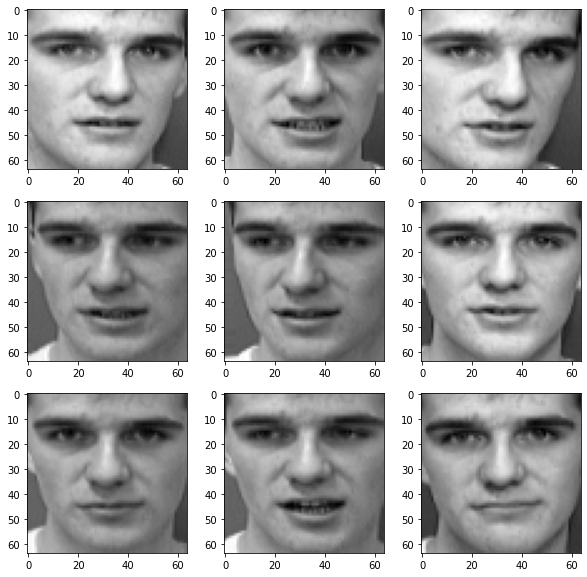

In [35]:
# 3x3 plot
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    # faces 291 to 299
    plt.imshow(data[i+290, :].reshape(64, 64), cmap='gray')
plt.show()

(4) Nehmen Sie die Folien zur heutigen Vorlesung zur Hand und schlagen Sie nach, wie die PCA definiert ist.

* Überlegen Sie sich die Dimensionen der Kovarianzmatrix des Datensatzes und nennen Sie sie hier.

Es gilt für einen Datensatz $X$ mit $n$ Samples und $m$ Features und entsprechender Kovarianzmatrix $S$:
$$
    \dim(S) = m \times m
$$

Und damit hier: 
$$
    \dim(S) = 4096 \times 4096
$$

(5) Bestimmen Sie die [Kovarianzmatrix](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) `cov_mat` des Datensatzes. Überprüfen Sie, ob die Dimensionen der Kovarianz mit Ihrer Erwartung aus Schritt (4) übereinstimmt.

* Hinweis: Eine typische Fehlerquelle besteht bei diesem Schritt darin, dass die Kovarianzmatrix nicht korrekt berechnet wird. Es ist daher wichtig, dass Sie wissen und überprüfen, ob die Dimensionen der Kovarianzmatrix stimmen.

In [2]:
# using numpy.cov

cov_mat = np.cov(data, rowvar=False)

print(cov_mat.shape)

(4096, 4096)


(6) [Bestimmen](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html) Sie nun die Eigenwerte `eig_vals` und Eigenvektoren `eig_vecs` Ihrer Kovarianzmatrix.

In [5]:
# using numpy.linalg.eig

# takes some time!!
eig_vals, eig_vecs = np.linalg.eigh(cov_mat)

(7) Ein typischer Fehler ist es, anzunehmen, dass Ihre Eigenwerte sortiert vorliegen. Dies ist im Allgemeinen *nicht* der Fall. Daher sortieren Sie bitte die Eigenwerte in absteigender Größe. Nutzen Sie dafür [diesen Befehl](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html), um die Sortierung in eine separate Variable `idx` zu speichern, mit der Sie dann die Sortierung der Eigenwerte vornehmen.

* Beachten Sie, dass der Ihnen angegebene Befehl nicht in absteigender Reihenfolge (*descending order*) sortieren kann. Sortieren Sie also zunächst aufsteigend und kehren Sie dann die Reihenfolge im resultierenden Array um. 
* Falls Sie glauben, dass Ihre Eigenwerte schon sortiert vorliegen, ohne dass Sie sortieren müssen, prüfen Sie dies nach, indem Sie sich die Variable `idx` anschauen.

In [6]:
# using numpy.argsort

idx = np.argsort(eig_vals)
print(eig_vals.shape)
idx = idx[::-1] # ::-1 = reverse
print(idx)
# sort eig_vals by idx
eig_vals = eig_vals[idx]

(4096,)
[4095 4094 4093 ...    2    1    0]


(8) Sortieren Sie nun die assoziierten Eigenvektoren, die Sie im Array `eig_vecs` gespeichert hatten.
* Beachten Sie: Die Eigenvektoren liegen als Spalten in `eigen_vecs` vor, *nicht* als Zeilen. Dies können Sie auch in der [Dokumentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) nachschlagen. Das Verwechseln von Zeilen und Spalten ist eine typische Fehlerquelle.
* Nutzen Sie `idx`, um die Spalten (also die Eigenvektoren) so zu sortieren, dass sie zu Ihren sortierten Eigenwerten passen. Dazu können Sie [Integer Array Indexing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#integer-array-indexing) einsetzen. Für Integer Array Indexing müssen Sie Ihr Array `idx` [in eine Python Liste umwandeln](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html).

In [7]:
# sort eig_vecs by idx
eig_vecs = eig_vecs[:, idx]

(9) Schlagen Sie in der Vorlesung nach, wie die *Proportion of Variance Explained* (PVE) definiert ist. Bestimmen Sie die PVE als Funktion der PCA-Komponenten und visualisieren Sie sie. Visualisieren Sie ebenfalls die kumulative PVE als Funktion der PCA-Komponenten.

* Beschreiben Sie kurz den Verlauf der PVE in Ihren beiden Abbildungen. Wie interpretieren Sie diesen Verlauf? (1-2 Sätze)

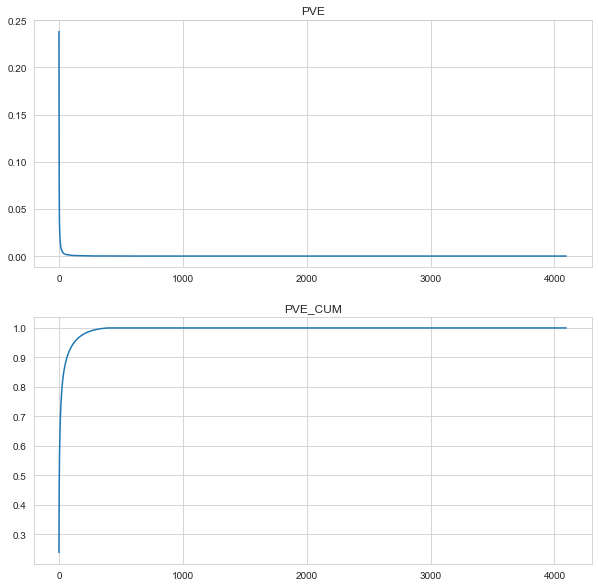

In [8]:
def pve(eig_vals):
    return np.array(eig_vals / np.sum(eig_vals))

plt.figure(figsize=(10, 10))
# plot pve and pve_cum using subplot
plt.subplot(2, 1, 1)
plt.plot(pve(eig_vals))
plt.title("PVE")
plt.subplot(2, 1, 2)
plt.plot(pve(eig_vals).cumsum())
plt.title("PVE_CUM")
plt.show()

(10) Wir untersuchen nun die Hauptkomponenten der PCA.

* Visualisieren Sie das erste Eigengesicht (*eigenface*). Dies entspricht der 1. PCA-Komponente, also dem Eigenvektor der Kovarianzmatrix, der dem größten Eigenwert zugeordnet ist. Dieser Eigenvektor wird auch als "erster Eigenvektor" bezeichnet.

* Visualisieren Sie ebenfalls die Eigengesichter 2 bis 5.

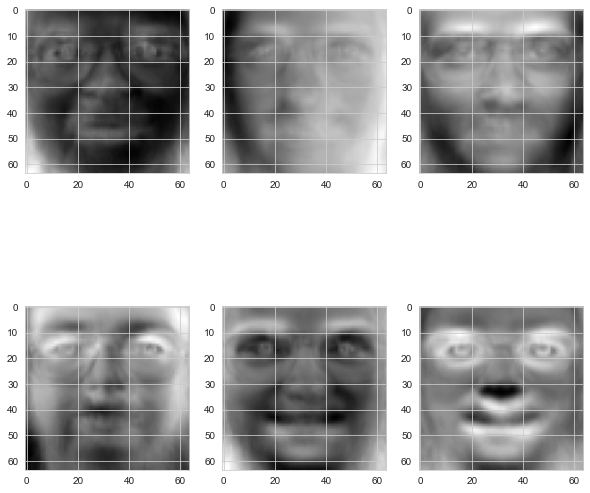

In [9]:
# 2x3 plot
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # eigenfaces
    # cast to real because of complex numbers with name
    plt.imshow(np.real(eig_vecs[:, i]).reshape(64, 64), cmap='gray')
plt.show()

(11) Die PCA-Komponenten (Eigengesichter) stellen eine Basis dar, mit der sich die Gesichter im Olivetti-Datensatz darstellen lassen. Ihre Erkenntnisse aus Teilaufgabe (9) deuten darauf hin, dass zur Darstellung der Gesichter nicht alle Basisvektoren notwendig sein werden. Dies werden Sie hier untersuchen.

Seien $\vec{f}_1, \ldots, \vec{f}_k$ die PCA-Komponenten der $k$-größten Eigenwerte, und bezeichne $\vec{g}$ der Vektor, der das Gesicht 296 (0-basierte Zählung) darstellt. Projizieren Sie das Gesicht $\vec{g}$ auf die ersten 25 PCA-Komponenten (Eigengesichter). Sie erhalten dadurch 25 Koeffizienten $c_i$,

$$c_i = \vec{f}_i^\text{T}(\vec{g}-\vec{m}),$$

wobei $\vec{m}$ der Vektor der Mittelwerte über die Merkmale des gesamten Datensatzes ist. Denn: Vergessen Sie nicht, dass Sie Ihre Daten *vor* der Projektion zentrieren müssen (schlagen Sie die entsprechende Folie in der Vorlesung nach). Dies bedeutet, dass Sie von den Merkmalen (Pixeln) des Gesichts 296 jeweils die Mittelwerte (ermittelt über den ganzen Datensatz) abziehen müssen.
  
Bemerkung:

* Sie haben hier das Gesicht 296 mithilfe von 25 Koeffizienten beschrieben und damit mit einem Vektor in einem 25-dimensionalen Raum. Dieser Raum ist deutlich kleiner als der ursprüngliche Raum (Dimensionsreduktion!). 


In [12]:
# centering data
data_mean = np.mean(data, axis=0)
print(data_mean.shape)
data_centered = data - data_mean
print(data_centered.shape)

(4096,)
(400, 4096)


In [11]:
coeffs = eig_vecs[:, :25].T @ data_centered[296, :]

print(coeffs.shape)

(25,)


(12) Sie haben aus Teilaufgabe (11) 25 Koffizienten vorliegen, mit denen Sie - mithilfe der Eigengesichter - nun das Gesicht rekonstruieren werden. Rekonstruieren Sie das Gesicht aus den 25 Koeffizienten mithilfe der Eigengesichter,

$$\vec{g}^\prime = \left(\sum\limits_{i=1}^k c_i \vec{f}_k\right) + \vec{m},$$

wobei Sie auch hier sich daran erinnern, dass Sie für die Rekonstruktion nun den Mittelwertsvektor $\vec{m}$, den Sie in Teilschritt (11) abgezogen hatten, wieder aufaddieren müssen.

* Visualisieren Sie in einem Plot das ursprüngliche Gesicht (links) sowie das rekonstruierte Gesicht (rechts).

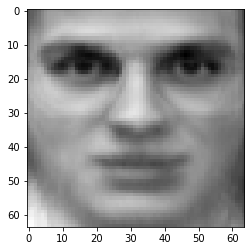

In [44]:
image = eig_vecs[:, :25] @ coeffs + data_mean

# show image
plt.imshow(np.real(image.reshape(64, 64)), cmap='gray')

(13) Experimentieren Sie mit einer größeren Anzahl von PCA-Komponenten und untersuchen Sie, wie sich die Projektion und die Rekonstruktion verbessert, wenn Sie die ersten 100 oder 200 PCA-Komponenten benutzen.

* Was beobachten Sie, wenn Sie die Anzahl der PCA-Komponenten erhöhen? (1-2 Sätze)

In [ ]:
n_coeffs = [1, 10, 25, 50, 100, 200]

for n in n_coeffs:
    coeffs = eig_vecs[:, :n].T @ data_centered[296, :]
    image = eig_vecs[:, :n] @ coeffs + data_mean
    plt.subplot(2, 3, n_coeffs.index(n)+1)
    plt.imshow(np.real(image.reshape(64, 64)), cmap='gray')
plt.show()


Wir beobachten - wie zu erwarten war - ein deutlich besser werdendes Bild mit anwachsender Anzahl der PCA-Komponenten.

(14) Nehmen Sie an, wir würden PCA als Bildkompressionsmethode einsetzen. Überdenken Sie folgendes Gedankenexperiment: Wir projizieren jedes Gesicht auf die 200 größten PCA-Komponenten (Eigengesichter) und erhalten jeweils 200 Koeffizienten pro Gesicht. Wir speichern nun diese Koeffizienten sowie die 200 PCA-Komponentenvektoren in einer Datei ab.

* Wie groß (in Megabytes) ist der Originaldatensatz, wenn wir zur Speicherung jedes Pixels 8 Bytes nutzen?
* Wie groß (in Megabytes) wäre der projizierte Datensatz, der lediglich die 200 Eigengesichter, die 200 Koeffizienten pro Gesicht sowie den Mittelwertsvektor ($\vec{m}$) enthält? Wir nehmen auch in diesem Fall an, dass jedes Pixel und jeder Koeffizient 8 Bytes belegt.

$$
\begin{align*}
\text{Originaldatensatz} &= 400 \cdot 64^2 \cdot 8 \text{ B} =  13.107.200 \text{ B} \approx 13.1 \text{ MB}\\
\text{Projizierter Datensatz} &= \underbrace{200 \cdot 64^2 \cdot 8 \text{ B}}_{\text{200 Eigengesichter}} + \underbrace{400 \cdot 200 \cdot 8 \text{ B}}_{\text{200 Koeffizienten pro Gesicht}} + \underbrace{64^2 \cdot 8 \text{ B}}_{\text{Mittelwertsvektor}} =  7.226.368 \text{ B} \approx 7.2 \text{ MB}
\end{align*}
$$

(15) \[Optional\] Nutzen Sie [ipython Widgets](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html), um eine interaktive Visualisierung der Gesichter des Datensatzes sowie ihrer Rekonstruktion zu erstellen: Legen Sie zwei Slider an: Mit dem ersten Slider können sie die Nummer des zu visualisierenden Gesichtes im Datensatz einstellen. Mit dem zweiten Slider können Sie die Anzahl der PCA-Komponenten für die Projektion und anschließende Rekonstruktion einstellen. Das Widget soll das ursprüngliche Gesicht sowie das rekonstruierte Gesicht darstellen.

In [17]:
# i is the data row
# j is the number of eigenvectors
def slider(i, j):
    # c_i = f_i^T (data[j, :] - mean)
    coeffs = np.sum(eig_vecs[:, :j].T * data_centered[i, :], axis=1)
    image = np.dot(eig_vecs[:, :j], coeffs) + data_mean
    
    # show reconstructed image and original image
    plt.subplot(1, 2, 1)
    plt.imshow(np.real(image).reshape(64, 64), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(np.real(data[i, :]).reshape(64, 64), cmap='gray')

interact(slider, i=(0, n_samples-1), j=(1, 200))

interactive(children=(IntSlider(value=199, description='i', max=399), IntSlider(value=100, description='j', ma…

<function __main__.slider(i, j)>

### 6.2 Kriminalitätsraten (EDA mithilfe der PCA)

In dieser Übung werden wir einen klassischen Datensatz untersuchen, der aus den USA stammt. Es handelt sich um eine Zusammenstellung der Kriminalitätsraten in verschiedenen Staaten der USA sowie um den Prozentsatz der Bevölkerung, der in urbanen Regionen lebt (*UrbanProp*) aus dem Jahr 1975. Bei den Kriminalitätsraten interessieren uns Morde (*murder*), Körperverletzungen (*assault*) sowie Vergewaltigungen (*rape*) pro 100000 Einwohner, aufgeschlüsselt nach US-Staaten. Der Datensatz stammt aus dem *World Almanac and Book of facts 1975* (Kriminalitätsraten) und den *Statistical Abstracts of the United States 1975* (Urbane Regionen).

**Ihre Daten**

* Sie finden den Datensatz, den Sie für diese Übung benötigen, [hier](https://data.bialonski.de/ds/USArrests.csv).

**Ihre Aufgaben**

(1) Importieren Sie den Datensatz und verschaffen Sie sich einen Überblick darüber, welche Merkmale (Features) Ihr Datensatz aufweist.

In [1]:
# get data from url https://data.bialonski.de/ds/USArrests.csv
# using pandas
import pandas as pd

data = pd.read_csv('USArrests.csv')

data.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


(2) Führen Sie eine explorative Analyse durch (mit Mitteln der deskriptiven Statistik, Visualisierung und Werkzeugen zur Ermittlung von Zusammenhängen (Korrelationen)). Schreiben Sie (1-3 Sätze) Ihre Befunde auf.

array([[<AxesSubplot:xlabel='Murder', ylabel='Murder'>,
        <AxesSubplot:xlabel='Assault', ylabel='Murder'>,
        <AxesSubplot:xlabel='UrbanPop', ylabel='Murder'>,
        <AxesSubplot:xlabel='Rape', ylabel='Murder'>],
       [<AxesSubplot:xlabel='Murder', ylabel='Assault'>,
        <AxesSubplot:xlabel='Assault', ylabel='Assault'>,
        <AxesSubplot:xlabel='UrbanPop', ylabel='Assault'>,
        <AxesSubplot:xlabel='Rape', ylabel='Assault'>],
       [<AxesSubplot:xlabel='Murder', ylabel='UrbanPop'>,
        <AxesSubplot:xlabel='Assault', ylabel='UrbanPop'>,
        <AxesSubplot:xlabel='UrbanPop', ylabel='UrbanPop'>,
        <AxesSubplot:xlabel='Rape', ylabel='UrbanPop'>],
       [<AxesSubplot:xlabel='Murder', ylabel='Rape'>,
        <AxesSubplot:xlabel='Assault', ylabel='Rape'>,
        <AxesSubplot:xlabel='UrbanPop', ylabel='Rape'>,
        <AxesSubplot:xlabel='Rape', ylabel='Rape'>]], dtype=object)

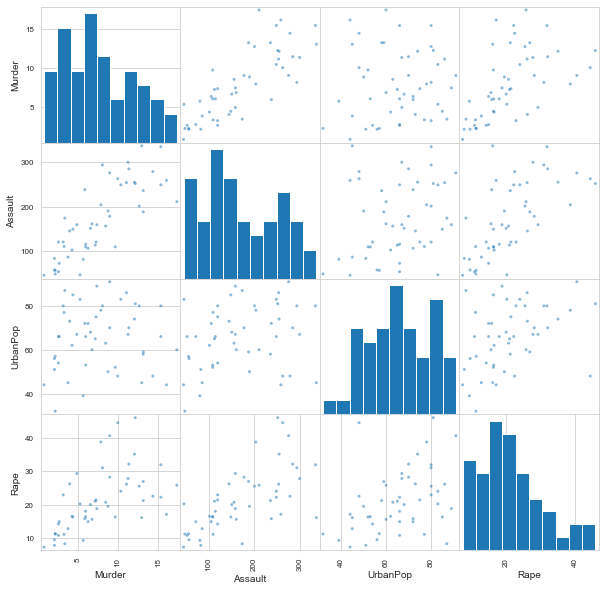

In [25]:
# 5 sum summary statistics
#data.describe()

pd.plotting.scatter_matrix(data, figsize=(10, 10))

In [2]:
# pearson rank correlation
data.corr(method='pearson')

,Murder,Assault,UrbanPop,Rape
Murder,1.000000,0.801873,0.069573,0.563579
Assault,0.801873,1.000000,0.258872,0.665241
UrbanPop,0.069573,0.258872,1.000000,0.411341
Rape,0.563579,0.665241,0.411341,1.000000


In [27]:
# spearmans rank correlation
data.corr(method='spearman')

,Murder,Assault,UrbanPop,Rape
Murder,1.000000,0.817274,0.106716,0.679427
Assault,0.817274,1.000000,0.275213,0.714368
UrbanPop,0.106716,0.275213,1.000000,0.438107
Rape,0.679427,0.714368,0.438107,1.000000


(3) Ermitteln Sie die Varianz der Merkmale. Welche Unterschiede stellen Sie fest? (1-2 Sätze).

In [28]:
# calculating variance
data.var()

C:\Users\Montahaee\AppData\Local\Temp\ipykernel_19536\588159488.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.var()


Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

Wir erkennen eine sehr hohe Varianz bei Assault, im Vergleich zu Murder und Rape.

Das liegt an den unterschiedlichen Skalierungen der Merkmale.

(4) Wir bereiten uns jetzt für eine Dimensionsreduktion per PCA vor. Klären Sie für sich zunächst: In welchen Skalen wurden die Merkmale gemessen? 

- `UrbanPop`: Prozentuale Bevölkerung in der Stadt
- alle anderen Merkmale: Anzahl Vorkommen pro  100.000 Einwohner

(5) Welche Vorbereitungsmaßnahme ergibt sich für Sie aus Punkt (4)? Bereiten Sie Ihre Daten entsprechend vor.
* ROT-13 kodierter Tipp: Fpunhra Fvr va qvr Ibeyrfhatfhagreyntra: Jvr fbyygra Fvr Vuer Qngra ibe rvare CPN genafsbezvrera?

Wir sollten die einzelnen Merkmale auf Varianz 1 skalieren -> normalisieren.

In [3]:
# normalize data except first column
data_norm = (data[data.columns[1:]] - data[data.columns[1:]].mean()) / data[data.columns[1:]].std()

# add back first column
data_norm.insert(0, data.columns[0], data[data.columns[0]])

data_norm.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,1.242564,0.782839,-0.520907,-0.003416
1,Alaska,0.507862,1.106823,-1.211764,2.484203
2,Arizona,0.071633,1.478803,0.998980,1.042878
3,Arkansas,0.232349,0.230868,-1.073593,-0.184917
4,California,0.278268,1.262814,1.758923,2.067820


(6) Nutzen Sie Ihre Implementierung der PCA aus Aufgabe 6.1 und führen Sie die PCA durch. Ihr Produkt sind die Merkmale in den neuen PCA-Koordinaten.

In [6]:
# cov_matrix (4 x 4)
cov_mat = np.cov(data_norm[data.columns[1:]], rowvar=False)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

idx = np.argsort(eig_vals)
idx = idx[::-1]
print(idx)
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

[0 1 3 2]


(7) Implementieren Sie eine Funktion, die Ihnen die *Proportion of Variance Explained* (PVE) für ein gegebenes Merkmal berechnet. Schlagen Sie dazu in der Vorlesung nach, wie die PVE definiert ist.

In [7]:
def pve_single(eig_val, eig_vals):
    return eig_val / np.sum(eig_vals)

(8) Visualisieren Sie die PVE als Funktion der PCA-Komponente: Erstellen Sie einen Plot, der die PVE der ersten, zweiten, usw. Komponente der PCA anzeigt.

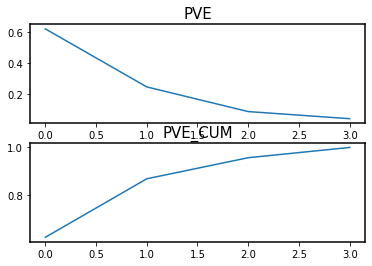

In [8]:
# plot pve and pve_cum using subplot
plt.subplot(2, 1, 1)
plt.plot(pve_single(eig_vals, eig_vals))
plt.title("PVE")

plt.subplot(2, 1, 2)
plt.plot(pve_single(eig_vals, eig_vals).cumsum())
plt.title("PVE_CUM")
plt.show()

(9) Ermitteln Sie die Anzahl der ersten PCA-Komponenten, mit deren Hilfe Sie etwas mehr als 85% der Gesamtvarianz erklären können. Notieren Sie sich diese Zahl.

In [9]:
count = sum = 0

for i in range(len(eig_vals)):
    sum += pve_single(eig_vals[i], eig_vals)
    count += 1
    if sum >= 0.85:
        break
    
print(count)

2


(10) Für die aus Schritt (9) ermittelte Anzahl an PCA Komponenten betrachten Sie nun die assoziierten Richtungsvektoren: Listen Sie die Komponenten der Richtungsvektoren in einer Tabelle (z.B. einem DataFrame), in der jede Spalte einen Richtungsvektor enthält und die Zeilen den Richtungsvektorkomponenten entsprechen. Beschriften Sie die Zeilen mit den Namen der Merkmale Ihres Datensatzes.

In [10]:
# pca component as column
# feature as row
pd.DataFrame(eig_vecs[:, :count].T, columns=data.columns[1:]).T

,0,1
Murder,0.535899,0.418181
Assault,0.583184,0.187986
UrbanPop,0.278191,-0.872806
Rape,0.543432,-0.167319


(11) Betrachten Sie nun Ihre Tabelle aus Schritt 10: Die Einträge der Richtungsvektoren entsprechen dem Gewicht, dem die PCA-Transformation dem entsprechenden Merkmal bei der Projektion auf die PCA-Richtung zuweist. Interpretieren Sie die Gewichte der 1. PCA Komponente: Welche Merkmale scheinen für die 1. PCA-Komponente wichtiger (bzw. gleich wichtig) zu sein, welche weniger wichtig? (1-3 Sätze)

Für die 1. PCA-Komponente scheinen die Merkmale `Murder`, `Assault` und `Rape` am ausschlaggebensten zu sein, dabei sind sie alle annähernd gleich wichtig.

(12) Interpretieren Sie die Gewichte der 2. PCA Komponente: Welche Merkmale scheinen für die 2. PCA-Komponente wichtiger (bzw. gleich wichtig) zu sein, welche weniger wichtig? (1-3 Sätze)

Am wichtigsten scheint `UrbanPop` zu sein - und das signifikant.
Sehr wenig relevant scheinen `Assault` und `Rape` zu sein.

(13) In Anbetracht Ihrer Beobachtungen aus Schritten (11) und (12): Welche Eigenschaften fasst die 1. PCA Komponente zusammen, welche die 2. PCA-Komponente? Welche ungefähren Namen würden Sie den PCA-Komponenten geben?

Die 1. PCA-Komponente scheint die Relationen zwischen den Straftaten zu beschreiben, die 2. das Verhältnis von urbaner bzw. ländlicher Bevölkerung.

(14) Visualisieren Sie die Daten in ihren in Schritt (9) ausgewählten PCA-Komponenten in einem Scatterplot. Beschriften Sie die Achsen mit den provisorischen Namen, die Sie ihnen in Schritt 13 gegeben haben.

(50, 4)
(2, 4)
         0         1         2         3         4         5         6   \
0  0.975660  1.930538  1.745443 -0.139999  2.498613  1.499341 -1.344992   
1  1.122001  1.062427 -0.738460  1.108542 -1.527427 -0.977630 -1.077984   

         7         8         9   ...        40        41        42        43  \
0  0.047230  2.982760  1.622807  ... -1.967797  0.989694  1.341518 -0.545032   
1 -0.322089  0.038834  1.266088  ...  0.815068  0.851605 -0.408335 -1.456715   

         44        45        46        47        48        49  
0 -2.773256 -0.095367 -0.214723 -2.087393 -2.058812 -0.623101  
1  1.388194  0.197728 -0.960374  1.410526 -0.605125  0.317787  

[2 rows x 50 columns]


Text(0, 0.5, 'PC2')

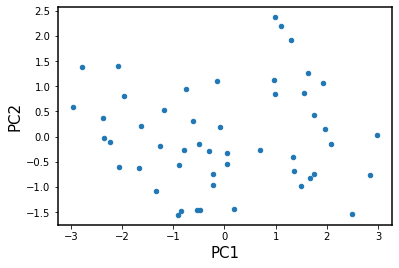

In [11]:
print(data_norm[data.columns[1:]].shape)
print(eig_vecs[:, :count].T.shape)

coeffs = eig_vecs[:, :count].T @ data_norm[data.columns[1:]].T

print(coeffs)

data_projected = eig_vecs[:, :count] @ coeffs

coeffs = coeffs.T

coeffs.plot.scatter(x=0, y=1)
plt.xlabel("PC1")
plt.ylabel("PC2")

### 6.3 z-scoring und PCA

In diesem Übungsteil werden wir uns noch einmal mit der PCA beschäftigen, allerdings dieses Mal auf konzeptioneller Ebene.

In der Vorlesung hatten wir die Kovarianzmatrix $S$ wie folgt definiert,

$$S = \frac{1}{N} \sum\limits_{n=1}^N (\mathbf{x}_n - \bar{\mathbf{x}}) (\mathbf{x}_n - \bar{\mathbf{x}})^T,$$

wobei $\mathbf{x}_n$ der Featurevektor des $n$-ten Datenpunktes und $\mathbf{\bar{x}}$ den Mittelwertsvektor über alle Datenpunkte bezeichnet.

**Ihre Aufgaben**

(1) Nutzen Sie die obige Definition von $S$ und berechnen Sie $S_{ij}$.

$$
\begin{align*}
S_{ij} &= \frac{1}{N} \sum_{n=1}^N \cdot (x_n - \bar{x})_{i} \cdot (x_n - \bar{x})_{j} \\
&= \frac{1}{N} \sum_{n=1}^N (x_{n_i} - \bar{x_i}) \cdot (x_{n_j} - \bar{x_j}) \\
&= \text{Cov}(x_i, x_j)
\end{align*}
$$
Wichtig ist hier noch anzumerken, dass $x_{n_i}$ die $i$-te Komponente im $n$-ten Datenpunkt ist und $\bar{x_i}$ der Mittelwert der $i$-ten Komponente.

(2) Zeigen Sie, dass $S$ symmetrisch ist, also das $S^\text{T} = S$. Diese Eigenschaft hatten wir im Beweis der PCA in der Vorlesung genutzt.

<!-- $$
\begin{align*}
& S^\text{T} = S \\
\iff\quad & S_{ij} = S_{ji} \quad\forall i,j \\
\iff\quad & \text{Cov}(ij) = \text{Cov}(ji)
\end{align*}
$$
Das ist offensichtlich aus der Definition der Kovarianz erfüllt. -->
$$
\begin{align*}
S_{ij} &= \frac{1}{N} \sum_{n=1}^N (x_{n_i} - \bar{x_i}) \cdot (x_{n_j} - \bar{x_j}) \\
&= \frac{1}{N} \sum_{n=1}^N (x_{n_j} - \bar{x_j}) \cdot (x_{n_i} - \bar{x_i}) \\
&= S_{ji} \\
\Rightarrow\quad & S = S^\text{T}
\end{align*}
$$

(3) Wir verschieben nun den Mittelwert der $n$ Datenpunkte $\mathbf{x}_n$, in dem wir jeweils den Vektor $\mathbf{a} \neq \mathbf{0}$ auf alle Datenpunkte addiert, also:
$$\tilde{\mathbf{x}}_n = \mathbf{x}_n + \mathbf{a}.$$
Bezeichne $S(\mathbf{x})$ die oben definierte Kovarianzmatrix und $S(\tilde{\mathbf{x}})$ die Kovarianzmatrix der transformierten Merkmale $\tilde{\mathbf{x}}_n$. Sind beide Matrizen unterschiedlich? Falls ja, warum? Falls nein, warum nicht?

Wir berechnen zuerst $\bar{\tilde{x}}$
$$
\bar{\tilde{x}} = \frac{1}{N} \sum_{n=1}^N \tilde{x}_n = \frac{1}{N} \sum_{n=1}^N x_n + a = \frac{1}{N} \left(N \cdot a + \sum_{n=1}^N x_n\right) = a + \frac{1}{N} \sum_{n=1}^N x_n = \bar{x} + a
$$

$$
\begin{align*}
S(\tilde{x}) &= \frac{1}{N} \sum_{n=1}^N (\tilde{x}_n - \bar{\tilde{x}}) \cdot (\tilde{x}_n - \bar{\tilde{x}})^T \\
&= \frac{1}{N} \sum_{n=1}^N (x_n+a - (\bar{x}+a)) \cdot (x_n+a - (\bar{x}+a))^T \\
&= \frac{1}{N} \sum_{n=1}^N (x_n - \bar{x}) \cdot (x_n - \bar{x})^T \\
&= S(x)
\end{align*}
$$

(4) Welche Konsequenzen hat eine Verschiebung der Mittelwerte auf die Richtungen der PCA? Argumentieren Sie ausgehend von Ihren Beobachtungen in Schritt (3). (1-3 Sätze)

Gar keine, wie wir sehen gilt $S(\tilde{x}) = S(x)$. Damit sind auch die Eigenvektoren von $S(\tilde{x})$ und $S(x)$ gleich. Das bedeutet die Richtungen der PCA sind unabhängig von der Transformation.

(5) In der Vorlesung wurde empfohlen, die Daten vor einer PCA zu zentrieren, sodass alle Merkmale Mittelwert $0$ haben. Welche Konsequenzen hat dies für die Richtungen der PCA? Orientieren Sie sich an Ihrer Antwort in Schritt (4).

Wie vorher schon erwähnt, sind die Richtungen unabhängig von der Transformation.

(6) Betrachten Sie zwei Szenarien: (a) Sie zentrieren Ihre Datenpunkte vor der Projektion auf die Richtungen der PCA. (b) Sie zentrieren Ihre Datenpunkte *nicht* vor der Projektion auf die Richtungen der PCA. Werden Sie in beiden Fällen dieselben PCA-Koordinaten Ihrer Datenpunkte erhalten? Falls ja, warum? Falls nein, warum nicht?

Man erhält unterschiedliche Datenpunkte, da die projezierten Datenpunkte in Fall (b) einen (unnötigen) Offset haben können.

(7) Nehmen wir an, dass Sie Ihre Merkmale standardisieren (also ein z-scoring durchführen). Betrachten Sie nun die Kovarianzmatrix $S$, wie sie zu Beginn der Aufgabe definiert ist. Diese Matrix $S$ entspricht einer weiteren Matrix, die Sie bereits kennen. Um welche Matrix handelt es sich?

Man benutzt ähnliche Formeln, um den Pearson Korrelationskoeffizient zu berechnen.